**Set up modules and database connection**

In [1]:
import configparser
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
config = configparser.ConfigParser()
config.read('config.ini')
conn = psycopg2.connect(
        host = config['postgres']['host'],
        dbname = config['postgres']['dbname'],
        user = config['postgres']['user']
    )

**Pull data from database and set up scatter chart function**

In [2]:
stock_sql="""
     SELECT *
     FROM reit_7_filled_data_combined
    """
data = pd.read_sql_query(stock_sql, conn)
conn.close()

In [3]:
def make_chart (x, y, type):
    chart_data = data[[x,y]]
    chart_data = chart_data[chart_data[y].notna()]
    chart_data = chart_data[chart_data[x].notna()]
    if type == 'scatter':
        sns.regplot(x=chart_data[x],y=chart_data[y])
    if type == 'line':
        chart_data.plot.line(x=x, y=y)

**As expected, Yield goes down as PE goes up**

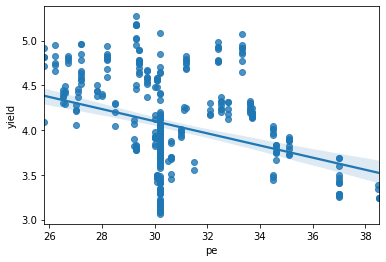

In [4]:
make_chart('pe','yield', 'scatter')

**In last 5 years, PE centered around 30-32**

<AxesSubplot:xlabel='pe'>

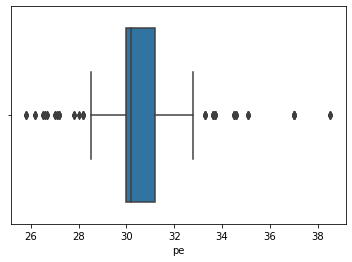

In [5]:
sns.boxplot(x=data['pe'])

**Current PE is 20% over typical, and highest ever**

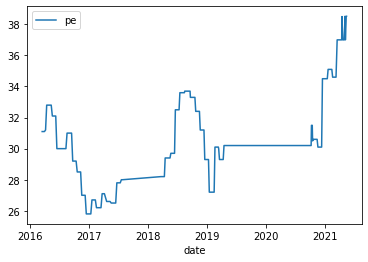

In [6]:
make_chart('date','pe', 'line')

**Compare macro-economic conditions against current smoothed price**<br>
Positive Linear relationship: SP500, Inflation (CPI, PPI), M3 Money Supply, new House starts<br>
Negative Linear relationship: Household Debt level, 10Y Interest Rate

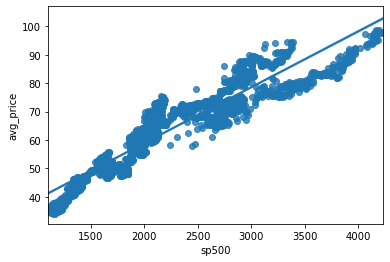

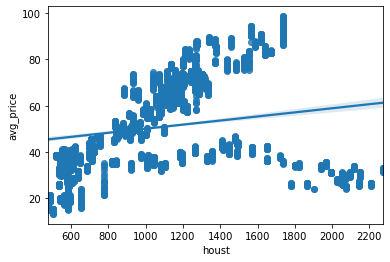

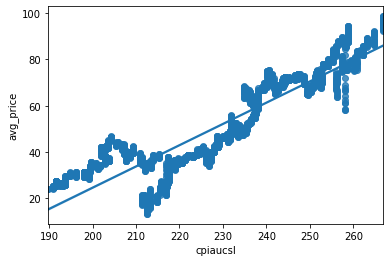

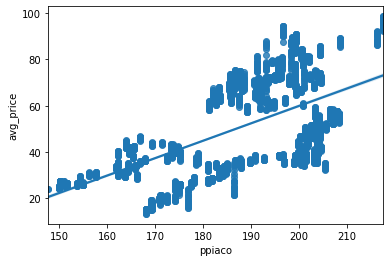

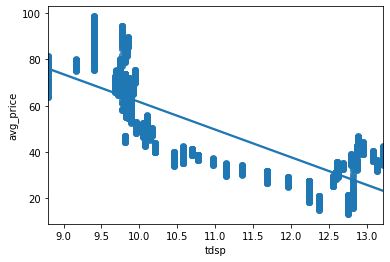

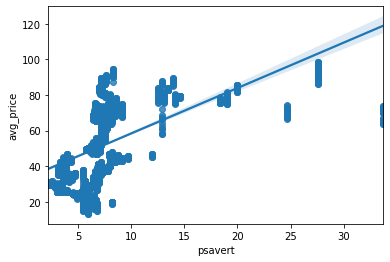

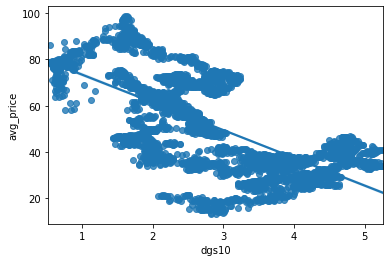

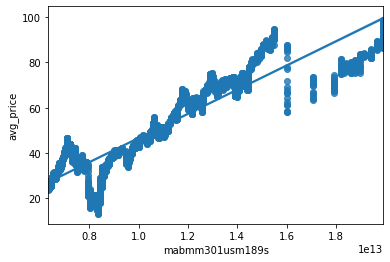

In [7]:
tests = [
    ('sp500','avg_price','scatter'),('houst','avg_price','scatter'),
    ('cpiaucsl','avg_price','scatter'),('ppiaco','avg_price','scatter'),
    ('tdsp','avg_price','scatter'),('psavert','avg_price','scatter'),
    ('dgs10','avg_price','scatter'),('mabmm301usm189s','avg_price','scatter')
        ]
for test in tests:
    plt.figure()
    make_chart(test[0],test[1],test[2])

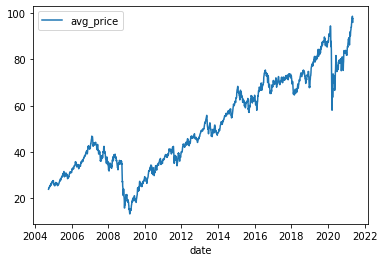

In [8]:
make_chart('date','avg_price', 'line')

**Compare macro-economic conditions against next month change in price**<br>
No significant linear relationship anywhere

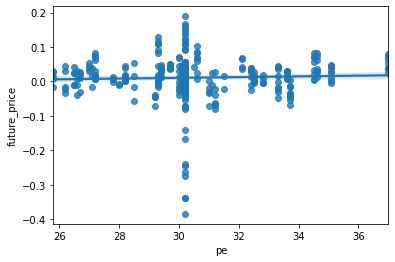

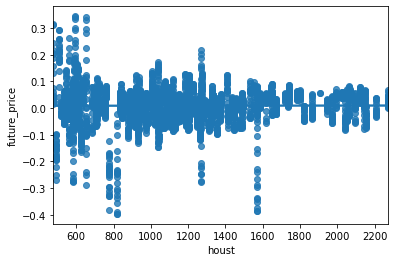

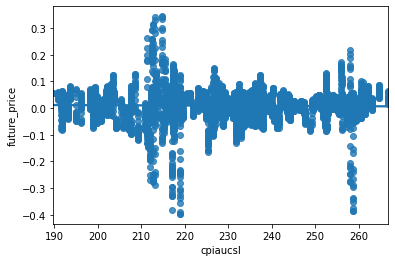

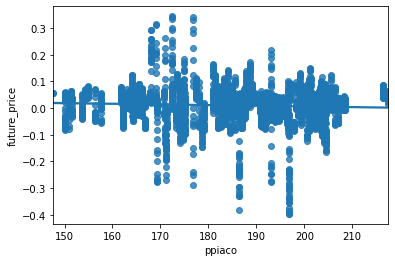

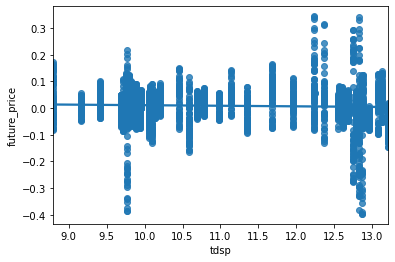

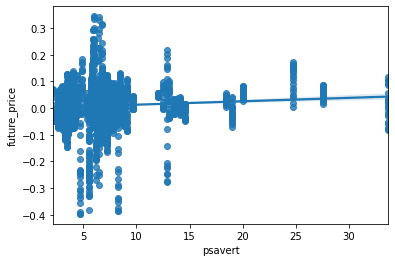

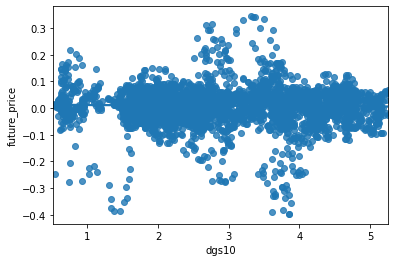

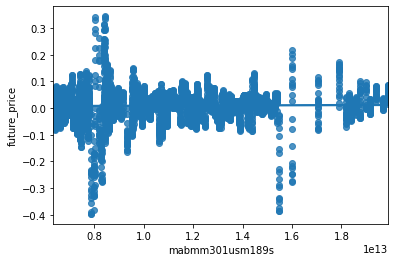

In [9]:
tests = [
    ('pe','future_price','scatter'),('houst','future_price','scatter'),
    ('cpiaucsl','future_price','scatter'),('ppiaco','future_price','scatter'),
    ('tdsp','future_price','scatter'),('psavert','future_price','scatter'),
    ('dgs10','future_price','scatter'),('mabmm301usm189s','future_price','scatter')
        ]
for test in tests:
    plt.figure()
    make_chart(test[0],test[1],test[2])

**Compare macro-economic 2 month/quarter changes against future price change**<br>
Weak Negative Linear relationship: increase in SP500, increase in Household Debt<br>
Everything else flat

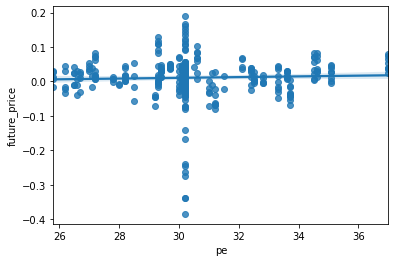

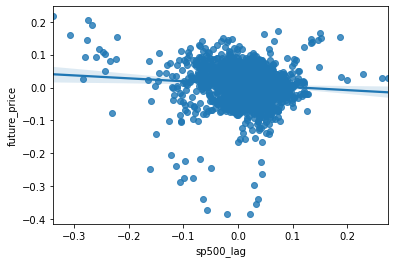

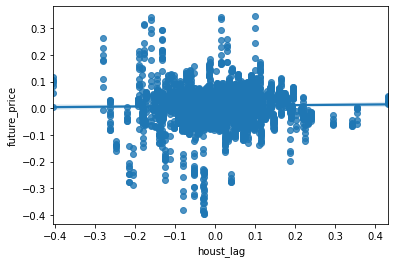

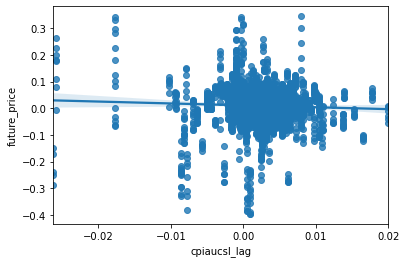

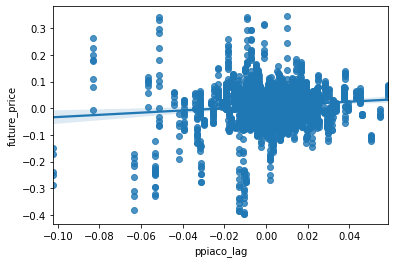

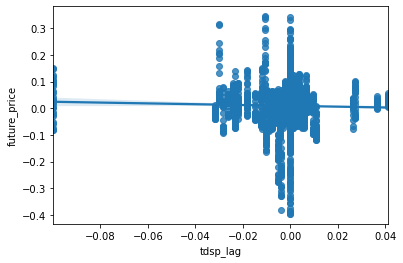

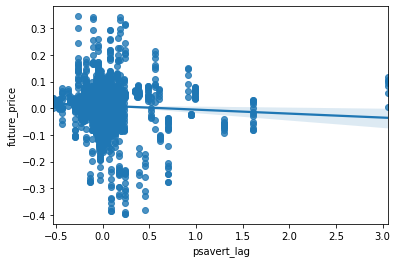

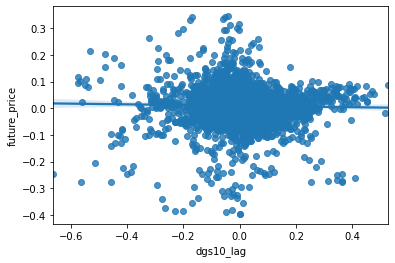

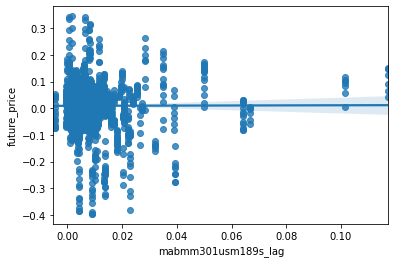

In [10]:
tests = [
    ('pe','future_price','scatter'), ('sp500_lag','future_price','scatter'),('houst_lag','future_price','scatter'),
    ('cpiaucsl_lag','future_price','scatter'),('ppiaco_lag','future_price','scatter'),
    ('tdsp_lag','future_price','scatter'),('psavert_lag','future_price','scatter'),
    ('dgs10_lag','future_price','scatter'),('mabmm301usm189s_lag','future_price','scatter')
        ]
for test in tests:
    plt.figure()
    make_chart(test[0],test[1],test[2])

In [11]:
reg = data[['avg_price','sp500', 'houst', 'cpiaucsl', 'ppiaco', 'tdsp', 'psavert', 'dgs10', 'mabmm301usm189s']]
reg = reg[reg['sp500'].notna()]
reg = reg[reg['houst'].notna()]
reg = reg[reg['cpiaucsl'].notna()]
reg = reg[reg['ppiaco'].notna()]
reg = reg[reg['tdsp'].notna()]
reg = reg[reg['psavert'].notna()]
reg = reg[reg['dgs10'].notna()]
reg = reg[reg['mabmm301usm189s'].notna()]

In refining the model, dropped 'ppiaco', 'houst', 'tdsp' from the regression for colinarity 

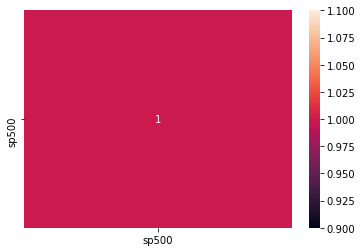

In [24]:
x = reg[['sp500']]
y = reg[['avg_price']]
corrMatrix = x.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [16]:
regr = linear_model.LinearRegression()
regr.fit(x,y)
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 [-29.57978174]
Coefficients: 
 [[ 2.76839776e-02  5.20408085e-03  6.49726981e-01 -4.38996028e-01
   3.14239835e+00 -3.38660455e+00 -5.30830761e-12]]


In [25]:
model = sm.OLS(y,x).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:              avg_price   R-squared (uncentered):                   0.986
Model:                            OLS   Adj. R-squared (uncentered):              0.986
Method:                 Least Squares   F-statistic:                          1.809e+05
Date:                Sat, 15 May 2021   Prob (F-statistic):                        0.00
Time:                        21:57:37   Log-Likelihood:                         -8716.2
No. Observations:                2518   AIC:                                  1.743e+04
Df Residuals:                    2517   BIC:                                  1.744e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------